# Building a scan programmatically with your own model

**In this notebook, we will be demonstrating how to create a scan in Certifai using your own model. We will show some examples of how to use models and datasets to run scans on your local environment**

#### Create a folder for Cortex Certifai, unzip the certifai toolkit and place the three libraries cortex-certifai-common, cortex-certifai-scanner & cortex-certifai-engine in a sub folder. Install Python from one of the selected versions which is available in the 'packages' sub folder under the certifai toolkit. Create two more sub folders for Data & Notebook respectively and place the csv and jupyter notebook 'regressor.ipynb' in those folders. Make sure the script 'cat_encoder.py' is placed in the same folder as the notebook to be used for encoding categorical values in the data.

#### Install the libraries

In [ ]:
!pip install cortex-certifai-common-1.3.4-126-g06d3fae5.zip
!pip install cortex-certifai-scanner-1.3.4-126-g06d3fae5.zip
!pip install cortex-certifai-engine-1.3.4-126-g06d3fae5-py3.6.10.zip
!pip install pandas_profiling
!pip install --upgrade matplotlib
!pip install lightgbm

In [1]:
import pandas as pd
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
import pandas_profiling as pp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn import svm
from copy import copy
import yaml
from cat_encoder import CatEncoder

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

**For multiprocessing to work in a Notebook, we need the encoder to be outside of the notebook. This code imports the encoder in a way that works in hosted notebooks as well as locally.**

# STEP (1): Setting up the dataset and model to be scanned

**Task 1): Setting up the dataset**

**Load the data into a DataFrame for use in both training and later analysing the model. In this example we use the customer spend dataset**

In [2]:
base_path = '/Path to the data folder/'
all_data_file = f"{base_path}/spend_data.csv"
df = pd.read_csv(all_data_file)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Term,Credit_History_Available,Housing,Locality,Spend
0,1,0,0,1,0,5849,0,146,360,1,1,1,87735
1,1,1,0,1,1,3000,0,66,360,1,1,1,45000
2,1,1,0,0,1,2583,2358,120,360,1,1,1,74115
3,1,0,0,1,0,6000,0,141,360,1,1,1,90000
4,1,1,0,0,1,2333,1516,95,360,1,1,1,57735


### Exploratory data analysis

In [3]:
pp.ProfileReport(df)

**Task 2): Set the categorical columns of the dataset up for the encoder (in our case we will encapsulate this in the CatEncoder class, which may be found in the same directory as this notebook). We will not use encoder in this notebook because the dataset does not have categorical values. We also note the column that contains the ground truth labels for training in 'label_column' (in this dataset this is 'Spend').**

In [4]:
y = df[df.columns[12:]]
X = df[df.columns[0:12]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


**Task 3) Fit the classification model**

In [5]:
def build_model_lr(data, name, test=None):
    if test is None:
        test = data
        
    model = LinearRegression()
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

linear_model = build_model_lr((X_train, y_train),'Logistic classifier', test=(X_test, y_test))

Model 'Logistic classifier' accuracy is 0.9854977411351052


**Task 6) Wrap up the model and the encoder so that Certifai sees it as part of the model**

In [6]:
linear_model_proxy = CertifaiPredictorWrapper(linear_model)

**Task 7) Compute model's accuracy with the test dataset**

In [7]:
linear_accuracy = linear_model.score(X_test, y_test)
print(f"Linear model accuracy on test data is {linear_accuracy}")

Linear model accuracy on test data is 0.9854977411351052


In [8]:
def build_model_rf(data, name, test=None):
    if test is None:
        test = data
        
    model = RandomForestRegressor()
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

rf_model = build_model_rf((X_train, y_train),'Random Forest Classifier',test=(X_test, y_test))

Model 'Random Forest Classifier' accuracy is 0.9790842300045868


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


In [9]:
rf_model_proxy = CertifaiPredictorWrapper(rf_model)

In [10]:
rf_accuracy = rf_model.score(X_test, y_test)
print(f"rf regressor model accuracy on test data is {rf_accuracy}")

rf regressor model accuracy on test data is 0.9790842300045868


In [11]:
def build_model_lgbm(data, name, test=None):
    if test is None:
        test = data

    model = LGBMRegressor()
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

lgbm_model = build_model_lgbm((X_train, y_train),'Light GBM Classifier', test=(X_test, y_test))

Model 'Light GBM Classifier' accuracy is 0.9268097599587446


In [12]:
lgbm_model_proxy = CertifaiPredictorWrapper(lgbm_model)

In [13]:
lgbm_accuracy = lgbm_model.score(X_test, y_test)
print(f"lgbm regressor model accuracy on test data is {lgbm_accuracy}")

lgbm regressor model accuracy on test data is 0.9268097599587446


In [14]:
def build_model_dt(data, name, test=None):
    if test is None:
        test = data
        
    model = DecisionTreeRegressor()
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

dt_model = build_model_dt((X_train, y_train),'Decision Tree Classifier',test=(X_test, y_test))

Model 'Decision Tree Classifier' accuracy is 0.9579728152327479


In [15]:
dt_model_proxy = CertifaiPredictorWrapper(dt_model)

In [16]:
dt_accuracy = dt_model.score(X_test, y_test)
print(f"dt regressor model accuracy on test data is {dt_accuracy}")

dt regressor model accuracy on test data is 0.9579728152327479


# Step (2) Create the scan object using the ScanBuilder class

**To allow easy working with Certifai from notebooks, or other programmatic use cases, the `ScanBuilder` class abstracts the scan definition and provides an object model to manipulate it.  Building up a definition in this way allows either direct running of the scan in the notebook, or export as a scan definition file, which can be run by the Certifai scanner.**

**Task 1) Define the outcomes of the classification task**

In [17]:
# Define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.regression(increased_favorable=True, absolute_threshold=0.5),
prediction_description='Predict the customer spend')

**Task 2) Create the Certifai scan object**

In [18]:
scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

**Task 3) Create the Certifai dataset from the local dataset**

In [19]:
# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))

**Task 4) Create the Certifai model from the local model**


In [20]:
# Add our local model
first_model = CertifaiModel('linear_regression',
                            local_predictor=linear_model_proxy)
scan.add_model(first_model)

In [21]:
# Add our local model
second_model = CertifaiModel('random_forest',
                            local_predictor=rf_model_proxy)
scan.add_model(second_model)

In [22]:
# Add our local model
third_model = CertifaiModel('light_GBM',
                            local_predictor=lgbm_model_proxy)
scan.add_model(third_model)

In [23]:
# Add our local model
fourth_model = CertifaiModel('decision_tree',
                            local_predictor=dt_model_proxy)
scan.add_model(fourth_model)

**Task 5) Setup an evaluation for fairness, robustness, and explainability on the above dataset using the model**

**We can have one or many of the following analysis types:**
- fairness
- robustness
- explainability
- explanation
- performance

In [24]:
scan.add_dataset(eval_dataset)
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('Gender'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('Married'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('Locality'))
scan.add_evaluation_type('fairness')
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('robustness')
scan.evaluation_dataset_id = 'evaluation'

**Task 6) Because the dataset contains a ground truth outcome column which the model does not expect to receive as input we need to state that in the dataset schema (since it cannot be inferred from the CSV) so that the scan can be rerun from the definition.**

In [25]:
scan.dataset_schema.outcome_feature_name = 'Spend'

**Task 7) Run the scan. 
    By default this will write the results into individual report files (one per model and evaluation
    type) in the 'reports' directory relative to the notebook.  This may be disabled by specifying
    `write_reports=False` as below**

In [26]:
#Run the Scan
result = scan.run(write_reports=True)

Starting scan with model_use_case_id: 'test_user_case' and scan_id: '0b0024ecd8e5'
[--------------------] 2020-10-02 14:58:14.375487 - 0 of 12 reports (0.0% complete) - Running fairness evaluation for model: linear_regression


2020-10-02 14:58:15,994 root   WARNING  Examples of protected class ('Gender', 1) exhausted before convergence after 340 samples
2020-10-02 14:58:15,995 root   WARNING  Examples of protected class ('Married', 1) exhausted before convergence after 174 samples
2020-10-02 14:58:15,997 root   WARNING  Examples of protected class ('Locality', 2) exhausted before convergence after 194 samples
2020-10-02 14:58:15,999 root   WARNING  Examples of protected class ('Gender', 0) exhausted before convergence after 139 samples
2020-10-02 14:58:16,001 root   WARNING  Examples of protected class ('Married', 0) exhausted before convergence after 305 samples
2020-10-02 14:58:16,002 root   WARNING  Examples of protected class ('Locality', 3) exhausted before convergence after 146 samples
2020-10-02 14:58:16,004 root   WARNING  Examples of protected class ('Locality', 1) exhausted before convergence after 139 samples


[#-------------------] 2020-10-02 14:58:24.538034 - 1 of 12 reports (8.33% complete) - Running explainability evaluation for model: linear_regression
[###-----------------] 2020-10-02 15:00:23.274528 - 2 of 12 reports (16.67% complete) - Running robustness evaluation for model: linear_regression
[#####---------------] 2020-10-02 15:02:31.348284 - 3 of 12 reports (25.0% complete) - Running fairness evaluation for model: random_forest


2020-10-02 15:02:38,831 root   WARNING  Examples of protected class ('Gender', 1) exhausted before convergence after 340 samples
2020-10-02 15:02:38,832 root   WARNING  Examples of protected class ('Married', 1) exhausted before convergence after 174 samples
2020-10-02 15:02:38,833 root   WARNING  Examples of protected class ('Locality', 2) exhausted before convergence after 194 samples
2020-10-02 15:02:38,834 root   WARNING  Examples of protected class ('Gender', 0) exhausted before convergence after 139 samples
2020-10-02 15:02:38,835 root   WARNING  Examples of protected class ('Married', 0) exhausted before convergence after 305 samples
2020-10-02 15:02:38,836 root   WARNING  Examples of protected class ('Locality', 3) exhausted before convergence after 146 samples
2020-10-02 15:02:38,837 root   WARNING  Examples of protected class ('Locality', 1) exhausted before convergence after 139 samples


[######--------------] 2020-10-02 15:02:46.635845 - 4 of 12 reports (33.33% complete) - Running explainability evaluation for model: random_forest
[########------------] 2020-10-02 15:04:18.138562 - 5 of 12 reports (41.67% complete) - Running robustness evaluation for model: random_forest
[##########----------] 2020-10-02 15:05:46.542413 - 6 of 12 reports (50.0% complete) - Running fairness evaluation for model: light_GBM


2020-10-02 15:05:54,067 root   WARNING  Examples of protected class ('Gender', 1) exhausted before convergence after 340 samples
2020-10-02 15:05:54,069 root   WARNING  Examples of protected class ('Married', 1) exhausted before convergence after 174 samples
2020-10-02 15:05:54,070 root   WARNING  Examples of protected class ('Locality', 2) exhausted before convergence after 194 samples
2020-10-02 15:05:54,071 root   WARNING  Examples of protected class ('Gender', 0) exhausted before convergence after 139 samples
2020-10-02 15:05:54,072 root   WARNING  Examples of protected class ('Married', 0) exhausted before convergence after 305 samples
2020-10-02 15:05:54,073 root   WARNING  Examples of protected class ('Locality', 3) exhausted before convergence after 146 samples
2020-10-02 15:05:54,074 root   WARNING  Examples of protected class ('Locality', 1) exhausted before convergence after 139 samples


[###########---------] 2020-10-02 15:06:01.651400 - 7 of 12 reports (58.33% complete) - Running explainability evaluation for model: light_GBM
[#############-------] 2020-10-02 15:07:53.170845 - 8 of 12 reports (66.67% complete) - Running robustness evaluation for model: light_GBM
[###############-----] 2020-10-02 15:09:43.753672 - 9 of 12 reports (75.0% complete) - Running fairness evaluation for model: decision_tree


2020-10-02 15:09:45,510 root   WARNING  Examples of protected class ('Gender', 1) exhausted before convergence after 340 samples
2020-10-02 15:09:45,512 root   WARNING  Examples of protected class ('Married', 1) exhausted before convergence after 174 samples
2020-10-02 15:09:45,514 root   WARNING  Examples of protected class ('Locality', 2) exhausted before convergence after 194 samples
2020-10-02 15:09:45,515 root   WARNING  Examples of protected class ('Gender', 0) exhausted before convergence after 139 samples
2020-10-02 15:09:45,517 root   WARNING  Examples of protected class ('Married', 0) exhausted before convergence after 305 samples
2020-10-02 15:09:45,519 root   WARNING  Examples of protected class ('Locality', 3) exhausted before convergence after 146 samples
2020-10-02 15:09:45,521 root   WARNING  Examples of protected class ('Locality', 1) exhausted before convergence after 139 samples


[################----] 2020-10-02 15:09:53.013935 - 10 of 12 reports (83.33% complete) - Running explainability evaluation for model: decision_tree
[##################--] 2020-10-02 15:11:12.383623 - 11 of 12 reports (91.67% complete) - Running robustness evaluation for model: decision_tree
[####################] 2020-10-02 15:12:35.724423 - 12 of 12 reports (100.0% complete) - Completed all evaluations


**The result is a dictionary keyed on analysis, containing reports keyed on model id **

**We will be extracting the score information in the form of a DataFrame from this dictionary**

In [27]:
df_f = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df_f)

df_r = construct_scores_dataframe(scores('robustness', result), include_confidence=False)
display(df_r)

df_e = construct_scores_dataframe(scores('explainability', result), include_confidence=False)
display(df_e)

,context,type,overall fairness,Feature (Gender),Group details (0) in Feature (Gender),Group details (1) in Feature (Gender),Feature (Locality),Group details (1) in Feature (Locality),Group details (2),Group details (3),Feature (Married),Group details (0) in Feature (Married),Group details (1) in Feature (Married)
linear_regression (burden),linear_regression,burden,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,100.0,1.0,1.0
random_forest (burden),random_forest,burden,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,100.0,1.0,1.0
light_GBM (burden),light_GBM,burden,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,100.0,1.0,1.0
decision_tree (burden),decision_tree,burden,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,100.0,1.0,1.0


,context,robustness
linear_regression,linear_regression,100.0
random_forest,random_forest,100.0
light_GBM,light_GBM,100.0
decision_tree,decision_tree,100.0


,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
linear_regression,linear_regression,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
random_forest,random_forest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
light_GBM,light_GBM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
decision_tree,decision_tree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merge the dataframes on 'contect' attribute

In [28]:
df_f_e = pd.merge(df_f, df_e, on='context')
df_complete = pd.merge(df_f_e, df_r, on='context')

In [29]:
df_complete.to_csv('/Path to the notebook directory/scan_results.csv', index=False)

The consolidated csv file can be shared across stakeholders, coders, architects for review and to select the best model for deployment.

### After the scan is complete, we can view the results in a UI. We have to open a command prompt, navigate to the 'reports' folder under the notebook directory using 'cd' command and type certifai console reports. The UI can be launched at http://localhost:8000/ for reviewing the results of the scan.

# Step (3) Creating the exportable scan object for models deployed as web service

**Task 1) Next we'll make modify the scan definition to make it suitable for running against a version of the model deployed as a web service, and export this scan definition as a YAML file. 

**The two things that need to be changed are:**
- *predict_endpoint*: Since the model will be running in a web service, we need to provide the URL for its intended predict endpoint
- *dataset url*: Similarly, since the data will be read from persistent storage rather than an already populated DataFrame, we'll need to modify the data source accordingly. If the URL is a relative file path, it will be interpreted relative to where the scan definition is stored.

For demo purpose, we are showing three model end points. 

In [30]:
scan.models[0].predict_endpoint = 'http://mymodel/logistic_regression/predict'
scan.models[1].predict_endpoint = 'http://mymodel/random_forest/predict'
scan.models[2].predict_endpoint = 'http://mymodel/light_GBM/predict'
scan.datasets[0].source = CertifaiDatasetSource.csv('path to the data folder/somefile.csv')

**The scan object contains the scan definition, which consists of all of the metadata needed to rerun the scan**

**Task 2) Viewing the scan definition**

In [31]:
print(scan.extract_yaml())

dataset_schema:
  outcome_column: Spend
datasets:
- dataset_id: evaluation
  delimiter: ','
  file_type: csv
  has_header: true
  quote_character: '"'
  url: somefile.csv
evaluation:
  evaluation_dataset_id: evaluation
  evaluation_types:
  - fairness
  - explainability
  - robustness
  fairness_grouping_features:
  - name: Gender
  - name: Married
  - name: Locality
  favorable_outcome_value: increased
  name: test_user_case
  prediction_description: Predict the customer spend
  prediction_favorability: ordered
  regression_boundary: 0.5
  regression_boundary_type: absolute
model_use_case:
  model_use_case_id: test_user_case
  name: test_user_case
  task_type: regression
models:
- model_id: linear_regression
  name: linear_regression
  predict_endpoint: http://mymodel/logistic_regression/predict
- model_id: random_forest
  name: random_forest
  predict_endpoint: http://mymodel/random_forest/predict
- model_id: light_GBM
  name: light_GBM
  predict_endpoint: http://mymodel/light_GBM/pr

**Task 3) Save the Scan Definition locally.**

**Save the scan definition to a file. The file path is relative to the notebook**

In [32]:
scan_file="/Path to the data folder/my_regressor_scan_definition.yaml"
with open(scan_file, "w") as f:
    scan.save(f)
    print(f"Saved template to: {scan_file}")

Saved template to: /Users/rksharathkumar/Desktop/RedHat_Openshift/Cortex_Certifai/examples/definitions/my_regressor_scan_definition.yaml


### Feature Importance using SHAP

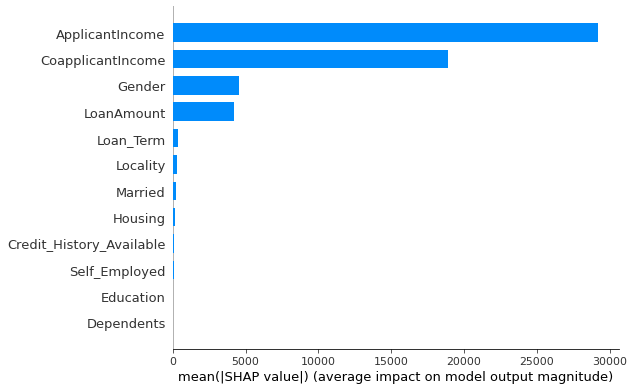

In [33]:
import shap
shap_values = shap.TreeExplainer(rf_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [40]:
import shap

In [42]:
shap.initjs()

In [45]:
shap_values = shap.TreeExplainer(rf_model).shap_values(X_train)

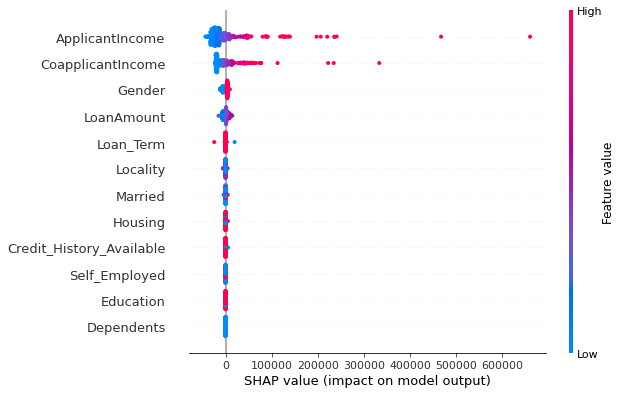

In [46]:
shap.summary_plot(shap_values, X_train)

In [47]:
X_train.mean()

Gender                         0.707572
Married                        0.373368
Dependents                     0.000000
Education                      0.778068
Self_Employed                  0.467363
ApplicantIncome             4765.900783
CoapplicantIncome           1619.835509
LoanAmount                   133.469974
Loan_Term                    339.718016
Credit_History_Available       0.895561
Housing                        0.634465
Locality                       2.002611
dtype: float64

In [48]:
y_train.mean()

Spend    91286.960836
dtype: float64

### Explaining how the model makes predictions

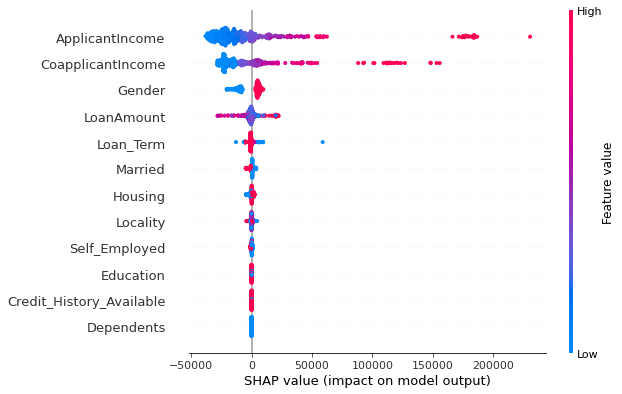

In [49]:
lgbm_shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_train)
shap.summary_plot(lgbm_shap_values, X_train)

### In the above plot, we can see that ApplicantIncome & CoapplicantIncome have high positive co-relation on customer spend which means higher the income, higher will be the customer spend. We can observe that, LoanAmount has high negative co-relation on customer spend which means lesser obligations will lead to more customer spend. We can observe how the model has learnt the datapoints and is making predictions accordingly.